## 📦 Loading the Dataset from Kaggle

The dataset is downloaded directly from Kaggle using the `kagglehub` package. This approach ensures that the most recent version of the dataset is used automatically.

Steps performed in this cell:

- Download the *Superstore Sales* dataset from Kaggle
- Locate the path to the extracted CSV file
- Read the CSV into a pandas DataFrame using `latin1` encoding (to handle special characters)
- Clean column names by:
  - Stripping leading/trailing spaces
  - Replacing spaces with underscores for easier reference

This sets up the data for further cleaning, exploration, and visualization.


In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")
filepath = os.path.join(path, os.listdir(path)[0]) 
print("Path to dataset files:\n", filepath )
df = pd.read_csv(filepath, encoding="latin1")
df.columns = df.columns.str.strip().str.replace(" ", "_")


## 📈 Monthly Sales Trend

This plot shows how sales have changed month over month.  
Sales tend to peak in November and December, indicating seasonal buying behavior, likely due to holidays.

Business Implication:  
Plan inventory and promotions in Q4 to take advantage of these peaks.


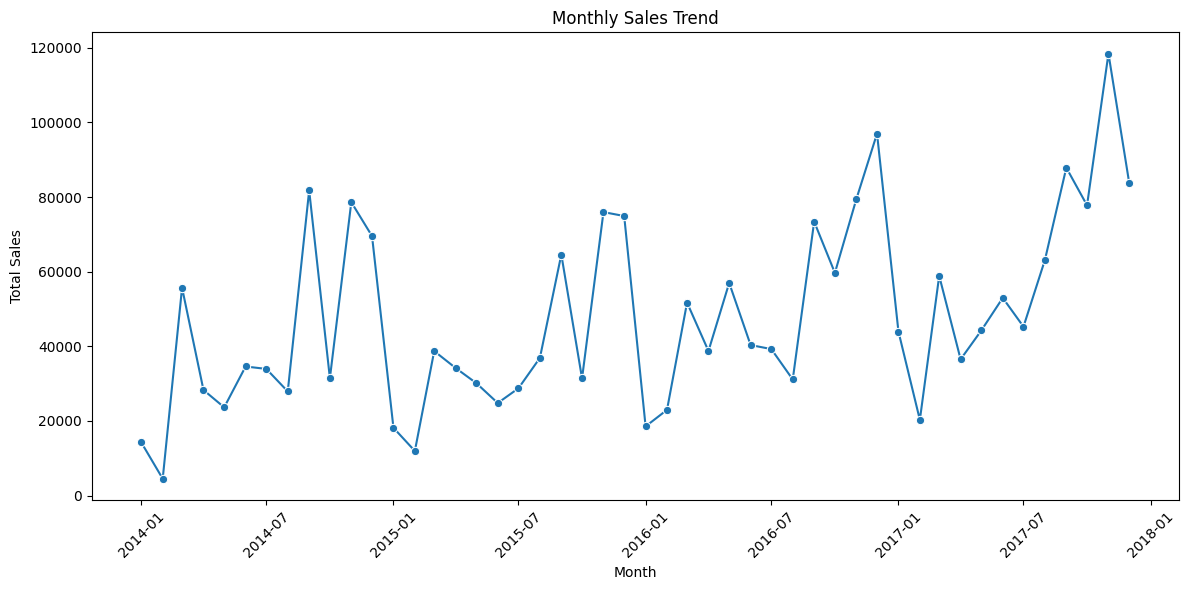

In [34]:
# Group sales by month
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Month'] = df['Order_Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()

# Convert to datetime (for plotting)
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Sales by Product Category

This bar chart shows the total sales by product category.  
It highlights which categories generate the most revenue overall.

**Key Insight:**  
The *Technology* category brings in the highest sales, followed by *Furniture* and *Office Supplies*.

**Business Implication:**  
Focus marketing, upselling, and inventory strategy around high-performing categories like Technology.


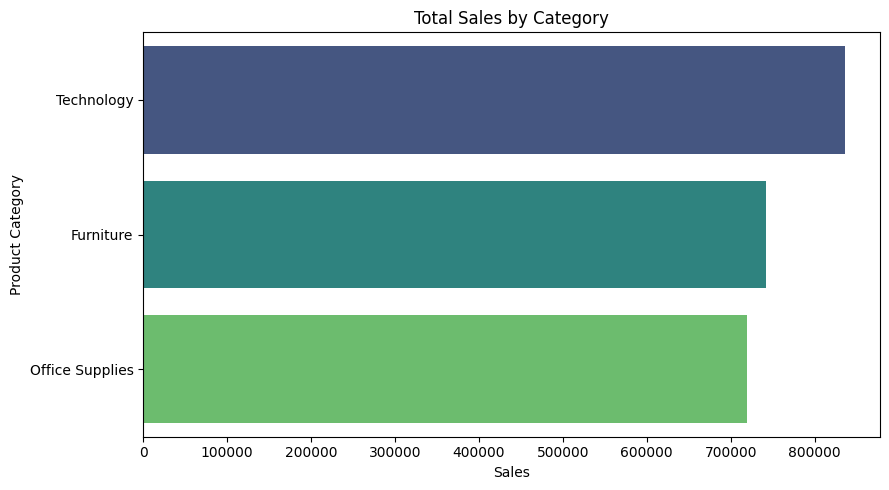

In [40]:
top_categories = df.groupby('Category')['Sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(9,5))
sns.barplot(data=top_categories, x='Sales', y='Category', hue='Category', palette='viridis', legend=False)
plt.title('Total Sales by Category')
plt.xlabel('Sales')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


## 🌍 Sales by Region

This visualization compares total sales across different regions.

**Key Insight:**  
The *West* and *East* regions outperform the *Central* and *South* regions in overall sales.

**Business Implication:**  
Regions with lower sales could be further analyzed to uncover potential for market expansion or improved outreach.


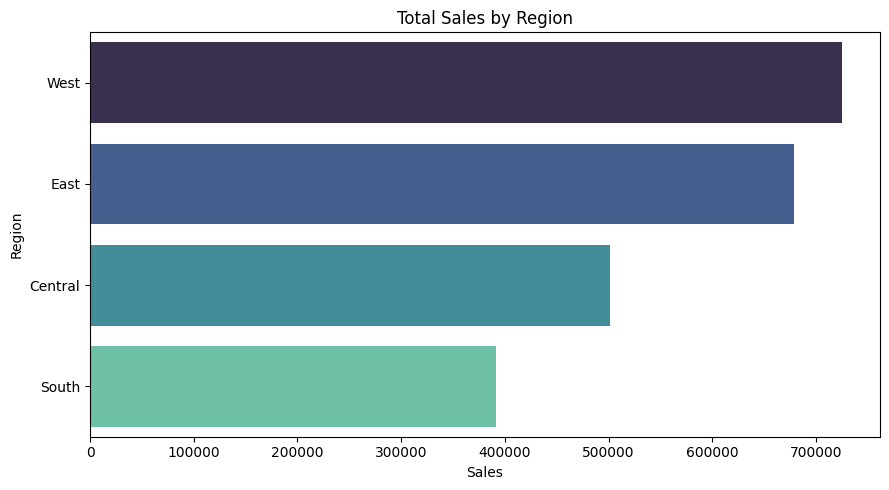

In [43]:
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(9,5))
sns.barplot(data=region_sales, x='Sales', y='Region', hue='Region', palette='mako', legend=False)
plt.title('Total Sales by Region')
plt.tight_layout()
plt.show()


## 💸 Sales vs. Discount

This scatter plot explores the relationship between discounts and sales.

**Key Insight:**  
While small discounts often correlate with higher sales, very high discounts (>30%) do not necessarily lead to higher revenue.  
There is significant variation, and in some cases, deep discounts may reduce profitability without boosting sales volume.

**Business Implication:**  
Optimize discount strategies to balance sales growth and profit margins. Avoid over-discounting unless it clearly drives demand.


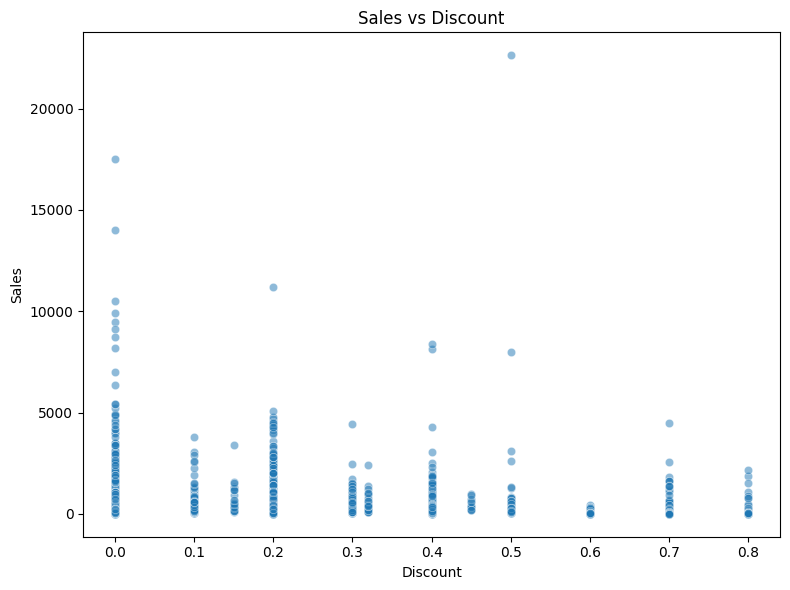

In [44]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Discount', y='Sales', alpha=0.5)
plt.title('Sales vs Discount')
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()
